In [37]:
import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

from scipy import stats
import statsmodels.api as sm
from itertools import product
from datetime import timedelta

import pandas as pd
pd.options.display.max_columns = 999
import numpy as np

from sklearn.metrics import mean_squared_error
#RMSE = mean_squared_error(y, y_pred)**0.5

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
%matplotlib inline
import matplotlib.pyplot as plt

In [38]:
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

## Подготовка данных

In [39]:
df_price = pd.read_csv('data/player_price.csv')
df_stats = pd.read_csv('data/player_stats.csv')
sample_subm = pd.read_csv('data/kaggle_sample_submission.csv')

sample_subm["player_id"] = sample_subm["id"].apply(lambda x: int(x.split("_")[0]))
sample_subm["Date"] = sample_subm["id"].apply(lambda x: np.datetime64(x.split("_")[1]))

#player_id=df_price.groupby(['player_id'])['xbox_price'].count()
player_id=sample_subm.groupby(['player_id'])['price'].count()

#df_price=df_price[df_price.player_id<=18320]
df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(['timestamp'], axis=1, inplace=True)
df_price.drop(['ps_price'],axis = 1, inplace=True)
df_price.rename(columns={'xbox_price':'price'}, inplace = True)

df_merge=df_stats[["player_id"]].merge(df_price, on=['player_id'], how='inner')

df_merge.shape

(980252, 4)

In [40]:
df_new_data=df_merge[df_merge.Date>='2017-05-22']
df_new_data

,player_id,price,player_name,Date
241,1,2971810,Pelé,2017-05-22
242,1,2925575,Pelé,2017-05-23
243,1,2909955,Pelé,2017-05-24
244,1,2918560,Pelé,2017-05-25
245,1,2974671,Pelé,2017-05-26
246,1,3071354,Pelé,2017-05-27
247,1,3010988,Pelé,2017-05-28
248,1,3116277,Pelé,2017-05-29
249,1,3223901,Pelé,2017-05-30
250,1,3221877,Pelé,2017-05-31


In [41]:
df_new_data_player=df_new_data[df_new_data.player_id==1]
print(df_new_data_player.shape)
df_new_data_player.tail(7)

(32, 4)


,player_id,price,player_name,Date
266,1,3212762,Pelé,2017-06-16
267,1,3312852,Pelé,2017-06-17
268,1,3227893,Pelé,2017-06-18
269,1,3142655,Pelé,2017-06-19
270,1,3135387,Pelé,2017-06-20
271,1,3248943,Pelé,2017-06-21
272,1,3137143,Pelé,2017-06-22


In [52]:
df=df_new_data_player[['Date','price']]
df=df.groupby('Date')[['price']].mean()
df=df.reset_index()
df.columns = ['ds', 'y']
#df=df.set_index('ds')
#df=df.replace(0,int(df.mean()))

df.head()

,ds,y
0,2017-05-22,2971810
1,2017-05-23,2925575
2,2017-05-24,2909955
3,2017-05-25,2918560
4,2017-05-26,2974671


In [53]:
df.y=np.log(df.y)
df.head()

,ds,y
0,2017-05-22,14.904682
1,2017-05-23,14.889002
2,2017-05-24,14.883648
3,2017-05-25,14.886601
4,2017-05-26,14.905644


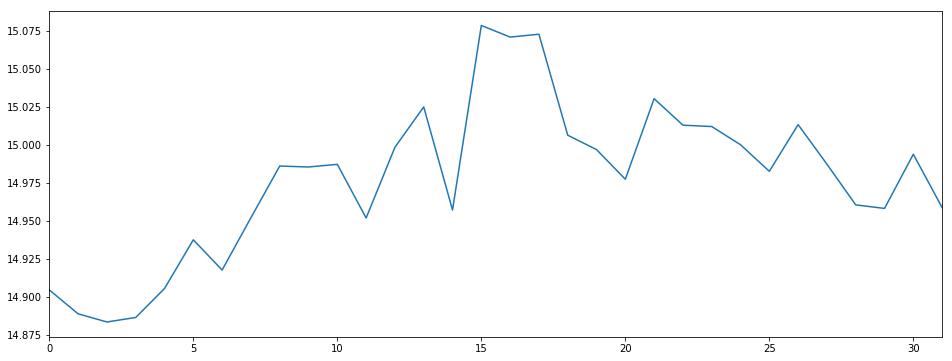

In [54]:
plt.figure(figsize=(16,6))
df.y.plot()

In [55]:
predictions = 7
#train_df=df
train_df = df[:-predictions]
train_df.head()

,ds,y
0,2017-05-22,14.904682
1,2017-05-23,14.889002
2,2017-05-24,14.883648
3,2017-05-25,14.886601
4,2017-05-26,14.905644


In [56]:
%%time
m = Prophet()
m.fit(train_df)

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Wall time: 141 ms


In [57]:
future = m.make_future_dataframe(periods=predictions)
future.tail(10)

,ds
22,2017-06-13
23,2017-06-14
24,2017-06-15
25,2017-06-16
26,2017-06-17
27,2017-06-18
28,2017-06-19
29,2017-06-20
30,2017-06-21
31,2017-06-22


In [58]:
forecast = m.predict(future)
forecast.tail()

,ds,t,trend,seasonal_lower,seasonal_upper,trend_lower,trend_upper,yhat_lower,yhat_upper,weekly,weekly_lower,weekly_upper,seasonal,yhat
27,2017-06-18,1.125000,14.979768,-0.012316,-0.012316,14.960616,14.997686,14.933208,15.001043,-0.012316,-0.012316,-0.012316,-0.012316,14.967453
28,2017-06-19,1.166667,14.975606,-0.005101,-0.005101,14.945129,15.005046,14.928940,15.012866,-0.005101,-0.005101,-0.005101,-0.005101,14.970505
29,2017-06-20,1.208333,14.971443,0.022146,0.022146,14.929353,15.012878,14.943931,15.043755,0.022146,0.022146,0.022146,0.022146,14.993589
30,2017-06-21,1.250000,14.967281,0.014963,0.014963,14.913694,15.022587,14.917835,15.045116,0.014963,0.014963,0.014963,0.014963,14.982244
31,2017-06-22,1.291667,14.963118,0.008073,0.008073,14.892765,15.032092,14.892347,15.043027,0.008073,0.008073,0.008073,0.008073,14.971191


In [122]:
print(', '.join(forecast.columns))

ds, t, trend, seasonal_lower, seasonal_upper, trend_lower, trend_upper, yhat_lower, yhat_upper, weekly, weekly_lower, weekly_upper, seasonal, yhat


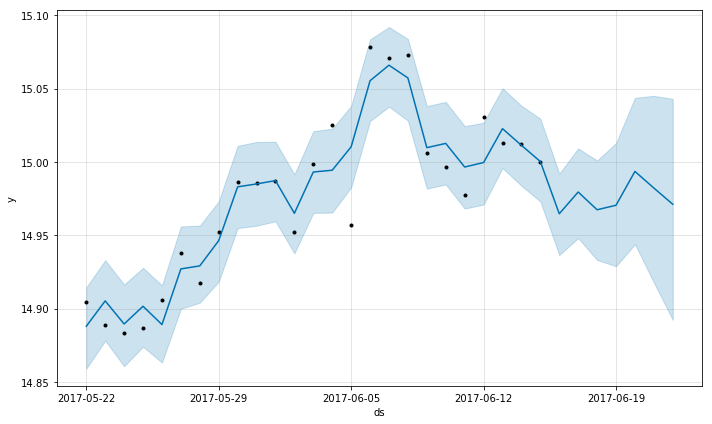

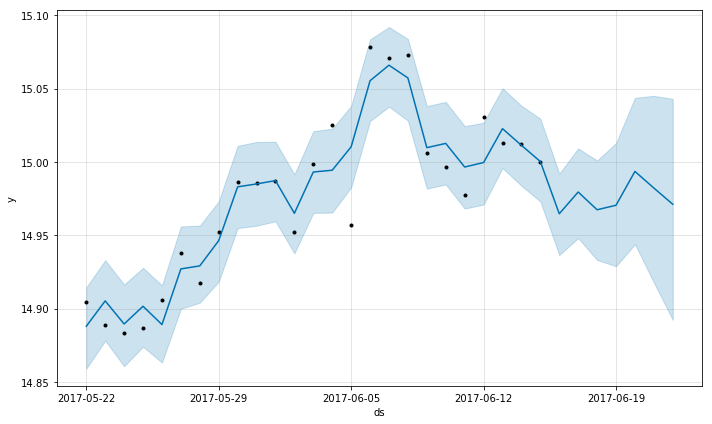

In [59]:
m.plot(forecast)

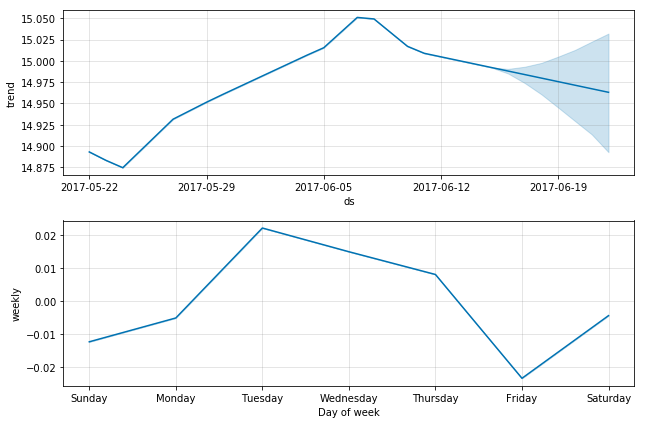

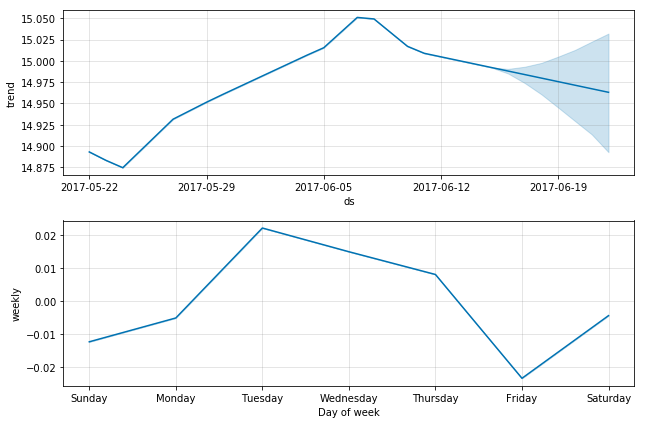

In [60]:
m.plot_components(forecast)

In [61]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE 0.13426709054203415
MAE 0.02011561783963676


In [62]:
def show_forecast(cmp_df, num_predictions, num_values):

    forecast = go.Scatter(
        name='Prophet',
        x=cmp_df.tail(predictions).index,
        y=cmp_df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )


    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )


    data = [forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='price'),
        title='price',
        showlegend = True)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, predictions, 200)

In [63]:
cmp_df.tail(20)

,yhat,yhat_lower,yhat_upper,y,e,p
ds,,,,,,
2017-06-03,14.993169,14.965280,15.021019,14.998420,0.005251,0.035010
2017-06-04,14.994401,14.965523,15.022718,15.024954,0.030553,0.203351
2017-06-05,15.010357,14.982692,15.038230,14.957211,-0.053146,-0.355318
2017-06-06,15.055402,15.027944,15.083574,15.078461,0.023059,0.152930
2017-06-07,15.066003,15.037718,15.092039,15.070828,0.004825,0.032014
2017-06-08,15.057303,15.028181,15.083829,15.072697,0.015393,0.102128
2017-06-09,15.009778,14.981831,15.038094,15.006366,-0.003412,-0.022738
2017-06-10,15.012674,14.984660,15.040994,14.996905,-0.015768,-0.105144
2017-06-11,14.996590,14.968244,15.024477,14.977439,-0.019151,-0.127864


In [64]:
mean_squared_error(df.y[-7:], cmp_df.yhat[-14:-7])**0.5

0.034916822369187785

In [65]:
qwe=cmp_df.yhat[-7:]
qwe

ds
2017-06-16    14.964722
2017-06-17    14.979535
2017-06-18    14.967453
2017-06-19    14.970505
2017-06-20    14.993589
2017-06-21    14.982244
2017-06-22    14.971191
Name: yhat, dtype: float64

In [66]:
qwe.values

array([ 14.96472196,  14.97953548,  14.9674525 ,  14.97050481,
        14.99358938,  14.98224352,  14.97119138])

In [68]:
np.exp(qwe)

ds
2017-06-16    3.155703e+06
2017-06-17    3.202798e+06
2017-06-18    3.164332e+06
2017-06-19    3.174005e+06
2017-06-20    3.248128e+06
2017-06-21    3.211483e+06
2017-06-22    3.176185e+06
Name: yhat, dtype: float64

In [4]:
22-14

8

In [21]:
df_price = pd.read_csv('data/player_price.csv')
df_stats = pd.read_csv('data/player_stats.csv')
sample_subm = pd.read_csv('data/kaggle_sample_submission.csv')

sample_subm["player_id"] = sample_subm["id"].apply(lambda x: int(x.split("_")[0]))
sample_subm["Date"] = sample_subm["id"].apply(lambda x: np.datetime64(x.split("_")[1]))

#player_id=df_price.groupby(['player_id'])['xbox_price'].count()
player_id=sample_subm.groupby(['player_id'])['price'].count()

#df_price=df_price[df_price.player_id<=18320]
df_price['Date'] = pd.to_datetime(df_price['timestamp'], unit='ms')
df_price.drop(['timestamp'], axis=1, inplace=True)
df_price.drop(['ps_price'],axis = 1, inplace=True)
df_price.rename(columns={'xbox_price':'price'}, inplace = True)

df_merge=df_stats[["player_id"]].merge(df_price, on=['player_id'], how='inner')

df_merge.shape

(980252, 4)

In [22]:
22-7

15

In [23]:
# 2017-06-04 prediction_fbpophet6
# 2017-06-08 prediction_fbpophet7
# 2017-06-15 prediction_fbpophet8
df_new_data=df_merge[df_merge.Date>='2017-06-15']
print(df_new_data.shape)
df_new_data.head()

(36786, 4)


,player_id,price,player_name,Date
265,1,3269308,Pelé,2017-06-15
266,1,3212762,Pelé,2017-06-16
267,1,3312852,Pelé,2017-06-17
268,1,3227893,Pelé,2017-06-18
269,1,3142655,Pelé,2017-06-19


In [24]:
player_id.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            18336, 18337, 18338, 18339, 18340, 18341, 18342, 18344, 18345,
            18370],
           dtype='int64', name='player_id', length=1253)

In [9]:
# 1_2017-06-23 \ 1_2017-06-29
#15621 нет в dataset

In [25]:
len(player_id)

1253

In [26]:
#list(range(15621,15624))
#len(player_id)
player_id.index[349]

3353

In [28]:
%%time
k=1
for i in player_id.index[350:len(player_id.index)]:#player_id.index
    print('==================================')
    print('id={}'.format(i))
    
    df_new_data_player=df_new_data[df_new_data.player_id==i]
        
    df=df_new_data_player[['Date','price']]
    df=df.groupby('Date')[['price']].mean()
    df=df.reset_index()
    df.columns = ['ds', 'y']
    
    train_df=df
    
    m = Prophet()
    m.fit(train_df)
    
    future = m.make_future_dataframe(periods=7)
    forecast = m.predict(future)
    
    cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))
    
    qwe=cmp_df.yhat[-7:]    
    #print(qwe)
    
    pp=pd.DataFrame(columns=['id','price'])
    pp['id']=str(i)+'_'+qwe.index.astype(str)
    pp.price=qwe.values
    pp.price=pp.price.astype(int)
    print(pp)
    
    if k==0:
        pp.to_csv('csv/prediction_fbpophet8.csv',sep=',',header=True,index=False)
        k=1
    else:
        with open('csv/prediction_fbpophet8.csv', 'a') as f:
            pp.to_csv(f, header=False,index=False,sep=',')

id=3365
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                id  price
0  3365_2017-06-23   3011
1  3365_2017-06-24   2683
2  3365_2017-06-25   2354
3  3365_2017-06-26   2026
4  3365_2017-06-27   1698
5  3365_2017-06-28   1370
6  3365_2017-06-29   1041
id=3376
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                id  price
0  3376_2017-06-23   1859
1  3376_2017-06-24   1223
2  3376_2017-06-25    587
3  3376_2017-06-26    -48
4  3376_2017-06-27   -684
5  3376_2017-06-28  -1320
6  3376_2017-06-29  -1955
id=3389
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                id  price


                id  price
0  4081_2017-06-23      0
1  4081_2017-06-24      0
2  4081_2017-06-25      0
3  4081_2017-06-26      0
4  4081_2017-06-27      0
5  4081_2017-06-28      0
6  4081_2017-06-29      0
id=4095
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                id  price
0  4095_2017-06-23   5091
1  4095_2017-06-24   5153
2  4095_2017-06-25   5214
3  4095_2017-06-26   5276
4  4095_2017-06-27   5337
5  4095_2017-06-28   5399
6  4095_2017-06-29   5460
id=4139
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                id  price
0  4139_2017-06-23   5676
1  4139_2017-06-24   6071
2  4139_2017-06-25   6466
3  4139_2017-06-26   6861
4  4139_2017-06-27   7255
5  4139_2017-06-28   7650
6  4139_2017-06-29   8045
id=4

                id  price
0  4956_2017-06-23    990
1  4956_2017-06-24    937
2  4956_2017-06-25    884
3  4956_2017-06-26    830
4  4956_2017-06-27    777
5  4956_2017-06-28    723
6  4956_2017-06-29    670
id=5152
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                id  price
0  5152_2017-06-23   5115
1  5152_2017-06-24   5283
2  5152_2017-06-25   5451
3  5152_2017-06-26   5620
4  5152_2017-06-27   5788
5  5152_2017-06-28   5957
6  5152_2017-06-29   6125
id=5412
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                id  price
0  5412_2017-06-23   3394
1  5412_2017-06-24   3581
2  5412_2017-06-25   3768
3  5412_2017-06-26   3955
4  5412_2017-06-27   4142
5  5412_2017-06-28   4329
6  5412_2017-06-29   4515
id=5

                 id  price
0  11793_2017-06-23   3617
1  11793_2017-06-24   4154
2  11793_2017-06-25   4692
3  11793_2017-06-26   5229
4  11793_2017-06-27   5767
5  11793_2017-06-28   6304
6  11793_2017-06-29   6841
id=14872
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  14872_2017-06-23    915
1  14872_2017-06-24    936
2  14872_2017-06-25    958
3  14872_2017-06-26    979
4  14872_2017-06-27   1001
5  14872_2017-06-28   1023
6  14872_2017-06-29   1044
id=14969
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  14969_2017-06-23   1076
1  14969_2017-06-24   1063
2  14969_2017-06-25   1050
3  14969_2017-06-26   1037
4  14969_2017-06-27   1024
5  14969_2017-06-28   1011
6  14

                 id  price
0  15090_2017-06-23  16421
1  15090_2017-06-24  16779
2  15090_2017-06-25  17136
3  15090_2017-06-26  17493
4  15090_2017-06-27  17851
5  15090_2017-06-28  18208
6  15090_2017-06-29  18565
id=15091
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  15091_2017-06-23  838431
1  15091_2017-06-24  833657
2  15091_2017-06-25  828884
3  15091_2017-06-26  824110
4  15091_2017-06-27  819337
5  15091_2017-06-28  814564
6  15091_2017-06-29  809790
id=15092
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  15092_2017-06-23  110750
1  15092_2017-06-24  109276
2  15092_2017-06-25  107802
3  15092_2017-06-26  106327
4  15092_2017-06-27  104853
5  15092_2017-06-2

                 id  price
0  15109_2017-06-23  13644
1  15109_2017-06-24  13712
2  15109_2017-06-25  13781
3  15109_2017-06-26  13849
4  15109_2017-06-27  13917
5  15109_2017-06-28  13985
6  15109_2017-06-29  14053
id=15110
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15110_2017-06-23  77975
1  15110_2017-06-24  76449
2  15110_2017-06-25  74924
3  15110_2017-06-26  73399
4  15110_2017-06-27  71873
5  15110_2017-06-28  70348
6  15110_2017-06-29  68823
id=15111
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15111_2017-06-23  12252
1  15111_2017-06-24  12125
2  15111_2017-06-25  11998
3  15111_2017-06-26  11871
4  15111_2017-06-27  11744
5  15111_2017-06-28  11617
6  15

                 id  price
0  15142_2017-06-23  24759
1  15142_2017-06-24  25341
2  15142_2017-06-25  25923
3  15142_2017-06-26  26505
4  15142_2017-06-27  27088
5  15142_2017-06-28  27670
6  15142_2017-06-29  28252
id=15143
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15143_2017-06-23  17695
1  15143_2017-06-24  17706
2  15143_2017-06-25  17718
3  15143_2017-06-26  17729
4  15143_2017-06-27  17741
5  15143_2017-06-28  17752
6  15143_2017-06-29  17764
id=15144
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15144_2017-06-23  38520
1  15144_2017-06-24  40201
2  15144_2017-06-25  41882
3  15144_2017-06-26  43563
4  15144_2017-06-27  45244
5  15144_2017-06-28  46925
6  15

                 id  price
0  15169_2017-06-23  18567
1  15169_2017-06-24  18437
2  15169_2017-06-25  18306
3  15169_2017-06-26  18176
4  15169_2017-06-27  18046
5  15169_2017-06-28  17915
6  15169_2017-06-29  17785
id=15170
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15170_2017-06-23  16602
1  15170_2017-06-24  14863
2  15170_2017-06-25  13124
3  15170_2017-06-26  11384
4  15170_2017-06-27   9645
5  15170_2017-06-28   7905
6  15170_2017-06-29   6166
id=15182
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15182_2017-06-23  37465
1  15182_2017-06-24  37067
2  15182_2017-06-25  36670
3  15182_2017-06-26  36273
4  15182_2017-06-27  35876
5  15182_2017-06-28  35479
6  15

                 id  price
0  15205_2017-06-23  53491
1  15205_2017-06-24  50803
2  15205_2017-06-25  48115
3  15205_2017-06-26  45427
4  15205_2017-06-27  42738
5  15205_2017-06-28  40050
6  15205_2017-06-29  37362
id=15206
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15206_2017-06-23  31605
1  15206_2017-06-24  29802
2  15206_2017-06-25  27999
3  15206_2017-06-26  26197
4  15206_2017-06-27  24394
5  15206_2017-06-28  22591
6  15206_2017-06-29  20789
id=15207
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15207_2017-06-23  46491
1  15207_2017-06-24  45454
2  15207_2017-06-25  44417
3  15207_2017-06-26  43380
4  15207_2017-06-27  42343
5  15207_2017-06-28  41306
6  15

                 id   price
0  15230_2017-06-23  267742
1  15230_2017-06-24  267233
2  15230_2017-06-25  266725
3  15230_2017-06-26  266217
4  15230_2017-06-27  265709
5  15230_2017-06-28  265201
6  15230_2017-06-29  264693
id=15231
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  15231_2017-06-23  158628
1  15231_2017-06-24  156193
2  15231_2017-06-25  153758
3  15231_2017-06-26  151323
4  15231_2017-06-27  148889
5  15231_2017-06-28  146454
6  15231_2017-06-29  144019
id=15232
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15232_2017-06-23  32074
1  15232_2017-06-24  34117
2  15232_2017-06-25  36159
3  15232_2017-06-26  38201
4  15232_2017-06-27  40244
5  15232_2017-06

                 id  price
0  15257_2017-06-23  21302
1  15257_2017-06-24  20499
2  15257_2017-06-25  19697
3  15257_2017-06-26  18894
4  15257_2017-06-27  18091
5  15257_2017-06-28  17288
6  15257_2017-06-29  16485
id=15258
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15258_2017-06-23  12593
1  15258_2017-06-24  12612
2  15258_2017-06-25  12630
3  15258_2017-06-26  12649
4  15258_2017-06-27  12667
5  15258_2017-06-28  12685
6  15258_2017-06-29  12704
id=15259
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15259_2017-06-23  12255
1  15259_2017-06-24  12260
2  15259_2017-06-25  12264
3  15259_2017-06-26  12269
4  15259_2017-06-27  12273
5  15259_2017-06-28  12277
6  15

                 id  price
0  15287_2017-06-23  19897
1  15287_2017-06-24  16066
2  15287_2017-06-25  12235
3  15287_2017-06-26   8404
4  15287_2017-06-27   4572
5  15287_2017-06-28    741
6  15287_2017-06-29  -3089
id=15288
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15288_2017-06-23  22293
1  15288_2017-06-24  22313
2  15288_2017-06-25  22333
3  15288_2017-06-26  22354
4  15288_2017-06-27  22374
5  15288_2017-06-28  22394
6  15288_2017-06-29  22415
id=15292
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15292_2017-06-23  58645
1  15292_2017-06-24  60395
2  15292_2017-06-25  62144
3  15292_2017-06-26  63894
4  15292_2017-06-27  65644
5  15292_2017-06-28  67393
6  15

                 id  price
0  15335_2017-06-23  24475
1  15335_2017-06-24  24517
2  15335_2017-06-25  24558
3  15335_2017-06-26  24600
4  15335_2017-06-27  24641
5  15335_2017-06-28  24683
6  15335_2017-06-29  24725
id=15337
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15337_2017-06-23  19523
1  15337_2017-06-24  19195
2  15337_2017-06-25  18867
3  15337_2017-06-26  18539
4  15337_2017-06-27  18212
5  15337_2017-06-28  17884
6  15337_2017-06-29  17556
id=15338
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15338_2017-06-23  19615
1  15338_2017-06-24  19565
2  15338_2017-06-25  19514
3  15338_2017-06-26  19464
4  15338_2017-06-27  19413
5  15338_2017-06-28  19363
6  15

                 id  price
0  15373_2017-06-23  21019
1  15373_2017-06-24  20706
2  15373_2017-06-25  20394
3  15373_2017-06-26  20081
4  15373_2017-06-27  19769
5  15373_2017-06-28  19456
6  15373_2017-06-29  19144
id=15374
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15374_2017-06-23  16257
1  15374_2017-06-24  16167
2  15374_2017-06-25  16077
3  15374_2017-06-26  15987
4  15374_2017-06-27  15897
5  15374_2017-06-28  15807
6  15374_2017-06-29  15717
id=15375
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15375_2017-06-23  36732
1  15375_2017-06-24  36761
2  15375_2017-06-25  36790
3  15375_2017-06-26  36820
4  15375_2017-06-27  36849
5  15375_2017-06-28  36878
6  15

                 id  price
0  15400_2017-06-23  16508
1  15400_2017-06-24  16409
2  15400_2017-06-25  16310
3  15400_2017-06-26  16210
4  15400_2017-06-27  16111
5  15400_2017-06-28  16012
6  15400_2017-06-29  15912
id=15402
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15402_2017-06-23  16303
1  15402_2017-06-24  15995
2  15402_2017-06-25  15687
3  15402_2017-06-26  15379
4  15402_2017-06-27  15072
5  15402_2017-06-28  14764
6  15402_2017-06-29  14456
id=15403
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15403_2017-06-23  16378
1  15403_2017-06-24  16039
2  15403_2017-06-25  15701
3  15403_2017-06-26  15363
4  15403_2017-06-27  15024
5  15403_2017-06-28  14686
6  15

                 id  price
0  15425_2017-06-23  17025
1  15425_2017-06-24  17231
2  15425_2017-06-25  17437
3  15425_2017-06-26  17644
4  15425_2017-06-27  17850
5  15425_2017-06-28  18057
6  15425_2017-06-29  18263
id=15426
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15426_2017-06-23  17904
1  15426_2017-06-24  17668
2  15426_2017-06-25  17432
3  15426_2017-06-26  17196
4  15426_2017-06-27  16960
5  15426_2017-06-28  16725
6  15426_2017-06-29  16489
id=15428
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  15428_2017-06-23  242981
1  15428_2017-06-24  236391
2  15428_2017-06-25  229802
3  15428_2017-06-26  223213
4  15428_2017-06-27  216623
5  15428_2017-06-28  21003

                 id   price
0  15456_2017-06-23  211469
1  15456_2017-06-24  209820
2  15456_2017-06-25  208172
3  15456_2017-06-26  206523
4  15456_2017-06-27  204875
5  15456_2017-06-28  203226
6  15456_2017-06-29  201578
id=15457
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15457_2017-06-23  95019
1  15457_2017-06-24  93004
2  15457_2017-06-25  90988
3  15457_2017-06-26  88972
4  15457_2017-06-27  86956
5  15457_2017-06-28  84941
6  15457_2017-06-29  82925
id=15458
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15458_2017-06-23  82643
1  15458_2017-06-24  81119
2  15458_2017-06-25  79594
3  15458_2017-06-26  78069
4  15458_2017-06-27  76544
5  15458_2017-06-28  750

                 id  price
0  15475_2017-06-23  49594
1  15475_2017-06-24  49484
2  15475_2017-06-25  49375
3  15475_2017-06-26  49265
4  15475_2017-06-27  49155
5  15475_2017-06-28  49046
6  15475_2017-06-29  48936
id=15491
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15491_2017-06-23   1083
1  15491_2017-06-24   1134
2  15491_2017-06-25   1185
3  15491_2017-06-26   1236
4  15491_2017-06-27   1287
5  15491_2017-06-28   1338
6  15491_2017-06-29   1389
id=15492
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15492_2017-06-23   6799
1  15492_2017-06-24   7650
2  15492_2017-06-25   8500
3  15492_2017-06-26   9350
4  15492_2017-06-27  10199
5  15492_2017-06-28  11050
6  15

                 id  price
0  15537_2017-06-23  35686
1  15537_2017-06-24  36447
2  15537_2017-06-25  37209
3  15537_2017-06-26  37971
4  15537_2017-06-27  38733
5  15537_2017-06-28  39494
6  15537_2017-06-29  40256
id=15538
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15538_2017-06-23  17290
1  15538_2017-06-24  17446
2  15538_2017-06-25  17601
3  15538_2017-06-26  17757
4  15538_2017-06-27  17912
5  15538_2017-06-28  18068
6  15538_2017-06-29  18224
id=15557
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  15557_2017-06-23  405110
1  15557_2017-06-24  391837
2  15557_2017-06-25  378563
3  15557_2017-06-26  365290
4  15557_2017-06-27  352017
5  15557_2017-06-28  33874

                 id  price
0  15592_2017-06-23  28403
1  15592_2017-06-24  28549
2  15592_2017-06-25  28694
3  15592_2017-06-26  28840
4  15592_2017-06-27  28985
5  15592_2017-06-28  29131
6  15592_2017-06-29  29276
id=15593
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15593_2017-06-23  82158
1  15593_2017-06-24  81330
2  15593_2017-06-25  80501
3  15593_2017-06-26  79672
4  15593_2017-06-27  78844
5  15593_2017-06-28  78015
6  15593_2017-06-29  77186
id=15594
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  15594_2017-06-23  449823
1  15594_2017-06-24  443719
2  15594_2017-06-25  437614
3  15594_2017-06-26  431509
4  15594_2017-06-27  425405
5  15594_2017-06-28  41930

                 id  price
0  15621_2017-06-23  15706
1  15621_2017-06-24  15322
2  15621_2017-06-25  14938
3  15621_2017-06-26  14553
4  15621_2017-06-27  14169
5  15621_2017-06-28  13785
6  15621_2017-06-29  13401
id=15622
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15622_2017-06-23  37020
1  15622_2017-06-24  36138
2  15622_2017-06-25  35256
3  15622_2017-06-26  34374
4  15622_2017-06-27  33492
5  15622_2017-06-28  32610
6  15622_2017-06-29  31728
id=15623
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15623_2017-06-23  94600
1  15623_2017-06-24  93782
2  15623_2017-06-25  92964
3  15623_2017-06-26  92145
4  15623_2017-06-27  91327
5  15623_2017-06-28  90509
6  15

                 id    price
0  15954_2017-06-23  2169703
1  15954_2017-06-24  2128336
2  15954_2017-06-25  2086969
3  15954_2017-06-26  2045602
4  15954_2017-06-27  2004235
5  15954_2017-06-28  1962868
6  15954_2017-06-29  1921501
id=15955
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id    price
0  15955_2017-06-23  1889268
1  15955_2017-06-24  1849526
2  15955_2017-06-25  1809785
3  15955_2017-06-26  1770044
4  15955_2017-06-27  1730302
5  15955_2017-06-28  1690561
6  15955_2017-06-29  1650819
id=15960
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  15960_2017-06-23  10458
1  15960_2017-06-24  11024
2  15960_2017-06-25  11590
3  15960_2017-06-26  12156
4  15960_2017-06-27  12722


                 id   price
0  15985_2017-06-23  598167
1  15985_2017-06-24  585206
2  15985_2017-06-25  572245
3  15985_2017-06-26  559284
4  15985_2017-06-27  546323
5  15985_2017-06-28  533362
6  15985_2017-06-29  520401
id=15986
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  15986_2017-06-23  359269
1  15986_2017-06-24  358429
2  15986_2017-06-25  357588
3  15986_2017-06-26  356748
4  15986_2017-06-27  355907
5  15986_2017-06-28  355067
6  15986_2017-06-29  354226
id=15987
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  15987_2017-06-23  252536
1  15987_2017-06-24  249414
2  15987_2017-06-25  246293
3  15987_2017-06-26  243171
4  15987_2017-06-27  240050
5  15987_2

                 id  price
0  16285_2017-06-23  30566
1  16285_2017-06-24  29604
2  16285_2017-06-25  28642
3  16285_2017-06-26  27680
4  16285_2017-06-27  26718
5  16285_2017-06-28  25756
6  16285_2017-06-29  24794
id=16286
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  16286_2017-06-23  21273
1  16286_2017-06-24  20732
2  16286_2017-06-25  20190
3  16286_2017-06-26  19649
4  16286_2017-06-27  19108
5  16286_2017-06-28  18567
6  16286_2017-06-29  18026
id=16287
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  16287_2017-06-23  17595
1  16287_2017-06-24  17628
2  16287_2017-06-25  17660
3  16287_2017-06-26  17693
4  16287_2017-06-27  17726
5  16287_2017-06-28  17759
6  16

                 id  price
0  16453_2017-06-23  20381
1  16453_2017-06-24  21594
2  16453_2017-06-25  22808
3  16453_2017-06-26  24021
4  16453_2017-06-27  25235
5  16453_2017-06-28  26448
6  16453_2017-06-29  27662
id=16455
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  16455_2017-06-23  36028
1  16455_2017-06-24  37152
2  16455_2017-06-25  38276
3  16455_2017-06-26  39401
4  16455_2017-06-27  40525
5  16455_2017-06-28  41649
6  16455_2017-06-29  42773
id=16456
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  16456_2017-06-23  82309
1  16456_2017-06-24  82785
2  16456_2017-06-25  83261
3  16456_2017-06-26  83738
4  16456_2017-06-27  84214
5  16456_2017-06-28  84690
6  16

                 id  price
0  16478_2017-06-23  18704
1  16478_2017-06-24  19083
2  16478_2017-06-25  19462
3  16478_2017-06-26  19841
4  16478_2017-06-27  20220
5  16478_2017-06-28  20599
6  16478_2017-06-29  20978
id=16479
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  16479_2017-06-23  12571
1  16479_2017-06-24  10717
2  16479_2017-06-25   8864
3  16479_2017-06-26   7011
4  16479_2017-06-27   5157
5  16479_2017-06-28   3304
6  16479_2017-06-29   1451
id=16480
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  16480_2017-06-23  116214
1  16480_2017-06-24  115337
2  16480_2017-06-25  114460
3  16480_2017-06-26  113583
4  16480_2017-06-27  112706
5  16480_2017-06-28  11182

                 id   price
0  16773_2017-06-23  118642
1  16773_2017-06-24  123127
2  16773_2017-06-25  127611
3  16773_2017-06-26  132096
4  16773_2017-06-27  136581
5  16773_2017-06-28  141066
6  16773_2017-06-29  145551
id=16774
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  16774_2017-06-23  17682
1  16774_2017-06-24  17706
2  16774_2017-06-25  17730
3  16774_2017-06-26  17754
4  16774_2017-06-27  17777
5  16774_2017-06-28  17801
6  16774_2017-06-29  17825
id=16775
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  16775_2017-06-23  26387
1  16775_2017-06-24  27140
2  16775_2017-06-25  27894
3  16775_2017-06-26  28648
4  16775_2017-06-27  29402
5  16775_2017-06-28  301

                 id  price
0  17069_2017-06-23  10146
1  17069_2017-06-24  10240
2  17069_2017-06-25  10333
3  17069_2017-06-26  10427
4  17069_2017-06-27  10521
5  17069_2017-06-28  10615
6  17069_2017-06-29  10709
id=17088
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17088_2017-06-23  23945
1  17088_2017-06-24  24608
2  17088_2017-06-25  25271
3  17088_2017-06-26  25934
4  17088_2017-06-27  26597
5  17088_2017-06-28  27260
6  17088_2017-06-29  27923
id=17141
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17141_2017-06-23   4731
1  17141_2017-06-24   5182
2  17141_2017-06-25   5632
3  17141_2017-06-26   6083
4  17141_2017-06-27   6533
5  17141_2017-06-28   6984
6  17

                 id  price
0  17236_2017-06-23  12463
1  17236_2017-06-24  11735
2  17236_2017-06-25  11008
3  17236_2017-06-26  10280
4  17236_2017-06-27   9552
5  17236_2017-06-28   8825
6  17236_2017-06-29   8097
id=17237
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17237_2017-06-23  43618
1  17237_2017-06-24  42358
2  17237_2017-06-25  41098
3  17237_2017-06-26  39837
4  17237_2017-06-27  38577
5  17237_2017-06-28  37317
6  17237_2017-06-29  36057
id=17238
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17238_2017-06-23  12646
1  17238_2017-06-24  12768
2  17238_2017-06-25  12890
3  17238_2017-06-26  13012
4  17238_2017-06-27  13134
5  17238_2017-06-28  13256
6  17

                 id  price
0  17255_2017-06-23  12068
1  17255_2017-06-24  12020
2  17255_2017-06-25  11972
3  17255_2017-06-26  11924
4  17255_2017-06-27  11876
5  17255_2017-06-28  11829
6  17255_2017-06-29  11781
id=17256
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17256_2017-06-23  17308
1  17256_2017-06-24  17098
2  17256_2017-06-25  16889
3  17256_2017-06-26  16679
4  17256_2017-06-27  16469
5  17256_2017-06-28  16260
6  17256_2017-06-29  16050
id=17257
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17257_2017-06-23   1255
1  17257_2017-06-24   1276
2  17257_2017-06-25   1296
3  17257_2017-06-26   1317
4  17257_2017-06-27   1338
5  17257_2017-06-28   1358
6  17

                 id  price
0  17279_2017-06-23  21245
1  17279_2017-06-24  21150
2  17279_2017-06-25  21055
3  17279_2017-06-26  20960
4  17279_2017-06-27  20865
5  17279_2017-06-28  20770
6  17279_2017-06-29  20675
id=17280
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17280_2017-06-23  12063
1  17280_2017-06-24  11405
2  17280_2017-06-25  10747
3  17280_2017-06-26  10089
4  17280_2017-06-27   9431
5  17280_2017-06-28   8772
6  17280_2017-06-29   8114
id=17281
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17281_2017-06-23  36092
1  17281_2017-06-24  36392
2  17281_2017-06-25  36692
3  17281_2017-06-26  36993
4  17281_2017-06-27  37293
5  17281_2017-06-28  37594
6  17

                 id  price
0  17375_2017-06-23  15422
1  17375_2017-06-24  15209
2  17375_2017-06-25  14995
3  17375_2017-06-26  14781
4  17375_2017-06-27  14567
5  17375_2017-06-28  14353
6  17375_2017-06-29  14139
id=17376
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17376_2017-06-23  41071
1  17376_2017-06-24  41684
2  17376_2017-06-25  42296
3  17376_2017-06-26  42909
4  17376_2017-06-27  43522
5  17376_2017-06-28  44134
6  17376_2017-06-29  44747
id=17377
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17377_2017-06-23  18879
1  17377_2017-06-24  19118
2  17377_2017-06-25  19357
3  17377_2017-06-26  19597
4  17377_2017-06-27  19836
5  17377_2017-06-28  20075
6  17

                 id   price
0  17446_2017-06-23  359864
1  17446_2017-06-24  355136
2  17446_2017-06-25  350409
3  17446_2017-06-26  345681
4  17446_2017-06-27  340954
5  17446_2017-06-28  336227
6  17446_2017-06-29  331499
id=17447
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  17447_2017-06-23  183798
1  17447_2017-06-24  180878
2  17447_2017-06-25  177958
3  17447_2017-06-26  175037
4  17447_2017-06-27  172117
5  17447_2017-06-28  169196
6  17447_2017-06-29  166276
id=17448
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17448_2017-06-23  82616
1  17448_2017-06-24  81299
2  17448_2017-06-25  79982
3  17448_2017-06-26  78664
4  17448_2017-06-27  77347
5  17448_2017-06

                 id  price
0  17537_2017-06-23   3189
1  17537_2017-06-24   3188
2  17537_2017-06-25   3188
3  17537_2017-06-26   3187
4  17537_2017-06-27   3186
5  17537_2017-06-28   3185
6  17537_2017-06-29   3184
id=17554
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17554_2017-06-23    895
1  17554_2017-06-24    773
2  17554_2017-06-25    651
3  17554_2017-06-26    530
4  17554_2017-06-27    408
5  17554_2017-06-28    286
6  17554_2017-06-29    164
id=17557
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17557_2017-06-23   4438
1  17557_2017-06-24   4298
2  17557_2017-06-25   4158
3  17557_2017-06-26   4019
4  17557_2017-06-27   3879
5  17557_2017-06-28   3740
6  17

                 id  price
0  17595_2017-06-23  16909
1  17595_2017-06-24  17029
2  17595_2017-06-25  17149
3  17595_2017-06-26  17269
4  17595_2017-06-27  17389
5  17595_2017-06-28  17509
6  17595_2017-06-29  17629
id=17598
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17598_2017-06-23  52806
1  17598_2017-06-24  53853
2  17598_2017-06-25  54900
3  17598_2017-06-26  55946
4  17598_2017-06-27  56993
5  17598_2017-06-28  58040
6  17598_2017-06-29  59086
id=17599
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17599_2017-06-23  15325
1  17599_2017-06-24  15406
2  17599_2017-06-25  15487
3  17599_2017-06-26  15568
4  17599_2017-06-27  15648
5  17599_2017-06-28  15729
6  17

                 id  price
0  17703_2017-06-23  12456
1  17703_2017-06-24  12355
2  17703_2017-06-25  12255
3  17703_2017-06-26  12154
4  17703_2017-06-27  12054
5  17703_2017-06-28  11953
6  17703_2017-06-29  11853
id=17704
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17704_2017-06-23  12757
1  17704_2017-06-24  12655
2  17704_2017-06-25  12553
3  17704_2017-06-26  12451
4  17704_2017-06-27  12349
5  17704_2017-06-28  12247
6  17704_2017-06-29  12145
id=17707
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  17707_2017-06-23  433480
1  17707_2017-06-24  429017
2  17707_2017-06-25  424554
3  17707_2017-06-26  420091
4  17707_2017-06-27  415629
5  17707_2017-06-28  41116

                 id  price
0  17881_2017-06-23  95247
1  17881_2017-06-24  93533
2  17881_2017-06-25  91818
3  17881_2017-06-26  90104
4  17881_2017-06-27  88390
5  17881_2017-06-28  86676
6  17881_2017-06-29  84961
id=17882
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17882_2017-06-23  44214
1  17882_2017-06-24  43098
2  17882_2017-06-25  41982
3  17882_2017-06-26  40867
4  17882_2017-06-27  39751
5  17882_2017-06-28  38636
6  17882_2017-06-29  37520
id=17883
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17883_2017-06-23  52498
1  17883_2017-06-24  51096
2  17883_2017-06-25  49694
3  17883_2017-06-26  48291
4  17883_2017-06-27  46889
5  17883_2017-06-28  45486
6  17

                 id   price
0  17912_2017-06-23  104843
1  17912_2017-06-24  101349
2  17912_2017-06-25   97855
3  17912_2017-06-26   94361
4  17912_2017-06-27   90866
5  17912_2017-06-28   87372
6  17912_2017-06-29   83878
id=17913
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  17913_2017-06-23  292679
1  17913_2017-06-24  285906
2  17913_2017-06-25  279134
3  17913_2017-06-26  272361
4  17913_2017-06-27  265589
5  17913_2017-06-28  258816
6  17913_2017-06-29  252044
id=17914
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17914_2017-06-23  36377
1  17914_2017-06-24  35674
2  17914_2017-06-25  34972
3  17914_2017-06-26  34270
4  17914_2017-06-27  33568
5  17914_2017-06

                 id   price
0  17938_2017-06-23  209534
1  17938_2017-06-24  208195
2  17938_2017-06-25  206855
3  17938_2017-06-26  205515
4  17938_2017-06-27  204176
5  17938_2017-06-28  202836
6  17938_2017-06-29  201496
id=17939
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17939_2017-06-23  21274
1  17939_2017-06-24  21297
2  17939_2017-06-25  21321
3  17939_2017-06-26  21345
4  17939_2017-06-27  21369
5  17939_2017-06-28  21393
6  17939_2017-06-29  21417
id=17940
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  17940_2017-06-23  73016
1  17940_2017-06-24  70471
2  17940_2017-06-25  67927
3  17940_2017-06-26  65383
4  17940_2017-06-27  62839
5  17940_2017-06-28  602

                 id  price
0  18046_2017-06-23  17223
1  18046_2017-06-24  17412
2  18046_2017-06-25  17600
3  18046_2017-06-26  17789
4  18046_2017-06-27  17977
5  18046_2017-06-28  18166
6  18046_2017-06-29  18354
id=18047
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18047_2017-06-23  44610
1  18047_2017-06-24  47260
2  18047_2017-06-25  49910
3  18047_2017-06-26  52560
4  18047_2017-06-27  55210
5  18047_2017-06-28  57860
6  18047_2017-06-29  60510
id=18054
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  18054_2017-06-23  262930
1  18054_2017-06-24  262432
2  18054_2017-06-25  261934
3  18054_2017-06-26  261436
4  18054_2017-06-27  260938
5  18054_2017-06-28  26043

                 id  price
0  18077_2017-06-23  12911
1  18077_2017-06-24  12836
2  18077_2017-06-25  12762
3  18077_2017-06-26  12687
4  18077_2017-06-27  12613
5  18077_2017-06-28  12539
6  18077_2017-06-29  12464
id=18114
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18114_2017-06-23  41883
1  18114_2017-06-24  40996
2  18114_2017-06-25  40109
3  18114_2017-06-26  39222
4  18114_2017-06-27  38335
5  18114_2017-06-28  37448
6  18114_2017-06-29  36561
id=18115
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18115_2017-06-23  41656
1  18115_2017-06-24  42237
2  18115_2017-06-25  42817
3  18115_2017-06-26  43398
4  18115_2017-06-27  43978
5  18115_2017-06-28  44559
6  18

                 id  price
0  18133_2017-06-23  13632
1  18133_2017-06-24  13505
2  18133_2017-06-25  13377
3  18133_2017-06-26  13250
4  18133_2017-06-27  13123
5  18133_2017-06-28  12995
6  18133_2017-06-29  12868
id=18134
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18134_2017-06-23  18609
1  18134_2017-06-24  18690
2  18134_2017-06-25  18771
3  18134_2017-06-26  18852
4  18134_2017-06-27  18933
5  18134_2017-06-28  19015
6  18134_2017-06-29  19096
id=18135
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18135_2017-06-23  17268
1  18135_2017-06-24  17329
2  18135_2017-06-25  17390
3  18135_2017-06-26  17450
4  18135_2017-06-27  17511
5  18135_2017-06-28  17572
6  18

                 id  price
0  18162_2017-06-23  19941
1  18162_2017-06-24  19767
2  18162_2017-06-25  19593
3  18162_2017-06-26  19419
4  18162_2017-06-27  19245
5  18162_2017-06-28  19071
6  18162_2017-06-29  18897
id=18163
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18163_2017-06-23  19998
1  18163_2017-06-24  20573
2  18163_2017-06-25  21148
3  18163_2017-06-26  21723
4  18163_2017-06-27  22299
5  18163_2017-06-28  22874
6  18163_2017-06-29  23449
id=18164
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18164_2017-06-23  17186
1  18164_2017-06-24  16951
2  18164_2017-06-25  16716
3  18164_2017-06-26  16480
4  18164_2017-06-27  16245
5  18164_2017-06-28  16010
6  18

                 id  price
0  18191_2017-06-23  14907
1  18191_2017-06-24  14790
2  18191_2017-06-25  14673
3  18191_2017-06-26  14556
4  18191_2017-06-27  14438
5  18191_2017-06-28  14321
6  18191_2017-06-29  14204
id=18192
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18192_2017-06-23  11855
1  18192_2017-06-24  11718
2  18192_2017-06-25  11581
3  18192_2017-06-26  11445
4  18192_2017-06-27  11308
5  18192_2017-06-28  11172
6  18192_2017-06-29  11035
id=18194
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18194_2017-06-23  65345
1  18194_2017-06-24  63895
2  18194_2017-06-25  62444
3  18194_2017-06-26  60994
4  18194_2017-06-27  59543
5  18194_2017-06-28  58093
6  18

                 id   price
0  18226_2017-06-23  114363
1  18226_2017-06-24  113759
2  18226_2017-06-25  113155
3  18226_2017-06-26  112551
4  18226_2017-06-27  111948
5  18226_2017-06-28  111344
6  18226_2017-06-29  110740
id=18262
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18262_2017-06-23  20037
1  18262_2017-06-24  20030
2  18262_2017-06-25  20023
3  18262_2017-06-26  20016
4  18262_2017-06-27  20009
5  18262_2017-06-28  20001
6  18262_2017-06-29  19994
id=18264
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  18264_2017-06-23  206089
1  18264_2017-06-24  202173
2  18264_2017-06-25  198258
3  18264_2017-06-26  194343
4  18264_2017-06-27  190427
5  18264_2017-06-2

Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id   price
0  18291_2017-06-23  373986
1  18291_2017-06-24  377129
2  18291_2017-06-25  380272
3  18291_2017-06-26  383415
4  18291_2017-06-27  386558
5  18291_2017-06-28  389701
6  18291_2017-06-29  392844
id=18292
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18292_2017-06-23  17226
1  18292_2017-06-24  17389
2  18292_2017-06-25  17553
3  18292_2017-06-26  17717
4  18292_2017-06-27  17880
5  18292_2017-06-28  18044
6  18292_2017-06-29  18208
id=18293
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18293_2017-06-23  18558
1  18293_2017-06-24  18908
2  18293_2017-06

                 id  price
0  18314_2017-06-23  17235
1  18314_2017-06-24  17500
2  18314_2017-06-25  17766
3  18314_2017-06-26  18032
4  18314_2017-06-27  18297
5  18314_2017-06-28  18563
6  18314_2017-06-29  18829
id=18315
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18315_2017-06-23  10373
1  18315_2017-06-24   8668
2  18315_2017-06-25   6962
3  18315_2017-06-26   5257
4  18315_2017-06-27   3551
5  18315_2017-06-28   1846
6  18315_2017-06-29    140
id=18316
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18316_2017-06-23  23019
1  18316_2017-06-24  23084
2  18316_2017-06-25  23149
3  18316_2017-06-26  23215
4  18316_2017-06-27  23280
5  18316_2017-06-28  23345
6  18

                 id  price
0  18338_2017-06-23  12780
1  18338_2017-06-24  12807
2  18338_2017-06-25  12834
3  18338_2017-06-26  12861
4  18338_2017-06-27  12888
5  18338_2017-06-28  12915
6  18338_2017-06-29  12942
id=18339
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18339_2017-06-23  13487
1  18339_2017-06-24  13203
2  18339_2017-06-25  12920
3  18339_2017-06-26  12637
4  18339_2017-06-27  12353
5  18339_2017-06-28  12070
6  18339_2017-06-29  11787
id=18340
Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
                 id  price
0  18340_2017-06-23  14338
1  18340_2017-06-24  14330
2  18340_2017-06-25  14323
3  18340_2017-06-26  14315
4  18340_2017-06-27  14308
5  18340_2017-06-28  14300
6  18

In [127]:
np.linspace(0, 100, 10000)

array([  0.00000000e+00,   1.00010001e-02,   2.00020002e-02, ...,
         9.99799980e+01,   9.99899990e+01,   1.00000000e+02])

In [ ]:
264 - 3107
271 - 2493
357 - 35879
1420 - 2763
1490 - 2552
2145 - 4993
3144 - 4584
3376 - 2551
4081 - 9348
4284 - 3243
6451 - 2408
9673 - 3011
14975 - 3316
15200 - 26973
15212 - 28844
15287 - 27472
15849 - 7279
16035 - 6822
16610 - 5475
17272 - 19565
17299 - 3384
17634 - 4671
17698 - 3998
18061 - 11193

In [1]:
df_merge.price[df_merge.player_id==17299].mean()

NameError: name 'df_merge' is not defined

In [ ]:
i=3353
print('==================================')
print('id={}'.format(i))

df_new_data_player=df_new_data[df_new_data.player_id==i]

df=df_new_data_player[['Date','price']]
df=df.groupby('Date')[['price']].mean()
df=df.reset_index()
df.columns = ['ds', 'y']
df=df[df!=0]

train_df=df

m = Prophet()
m.fit(train_df)

future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

qwe=cmp_df.yhat[-7:]    
#print(qwe)

pp=pd.DataFrame(columns=['id','price'])
pp['id']=str(i)+'_'+qwe.index.astype(str)
pp.price=qwe.values
pp.price=pp.price.astype(int)
print(pp)